# 0.0 IMPORTS


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import pickle
import xgboost           as xgb
from matplotlib             import pyplot as plt

from IPython.core.display   import HTML
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from lightgbm             import LGBMClassifier

## 0.1 Helper Functions



In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def precision_at_k(data, k=2000):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[ k, 'precision_at_k'], data)

def recall_at_k(data, k=2000):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[ k, 'recall_at_k'], data)

def cross_validation(models_performance_cv, num_folds, model_name, model, x_train, y_train):

    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()

        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        model_fit = model.fit(x_train_fold, y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        x_val_fold['score'] = yhat_model[:, 1].tolist()
        x_val_fold = x_val_fold.sort_values('score', ascending=False)
        
        precision = round(precision_at_k(x_val_fold, 2000)[0], 3)
        recall= round(recall_at_k(x_val_fold, 2000)[0], 3)
        
        precision_list.append(precision)
        recall_list.append(recall)

        i+=1
    
    precision_str = np.round(np.mean(precision_list), 4).astype(str) + ' +/- ' + np.round(np.std(precision_list), 4).astype(str)
    recall_str = np.round(np.mean(recall_list), 4).astype(str) + ' +/- ' + np.round(np.std(recall_list), 4).astype(str)

    model_performance = pd.DataFrame({'Model':[model_name], "precision_at_k": [precision_str], "recall_at_k": [recall_str]}) 

    models_performance_cv = pd.concat([models_performance_cv, model_performance])

    return models_performance_cv

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data


In [3]:
df1 = pd.read_csv('train.csv', delim_whitespace=False)
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [34]:
df1.shape

(381109, 12)

# 1.0 Data Description


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.1 Data Dimensions


In [5]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.2 Data Types


In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA



In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Change Data Types



In [4]:
# policy_sales_channel
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')
# region_code 
df1['region_code'] = df1['region_code'].astype('int64')

## 1.5 Descriptive Statistics


In [9]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

In [39]:
num_attributes.head()

,age,annual_premium,vintage
0,23,23367.0,249
1,41,31409.0,221
2,25,46622.0,299
3,26,2630.0,136
4,45,42297.0,264


In [40]:
cat_attributes.head()

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,response
0,Male,11,152,1,< 1 Year,Yes,0,0
1,Female,15,14,1,1-2 Year,No,1,0
2,Female,35,152,1,< 1 Year,No,1,0
3,Female,8,160,1,< 1 Year,No,0,0
4,Male,8,124,1,1-2 Year,Yes,0,0


### 1.5.1 Numerical Attributes



In [38]:
# métricas de tendência central - média, mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersão - desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


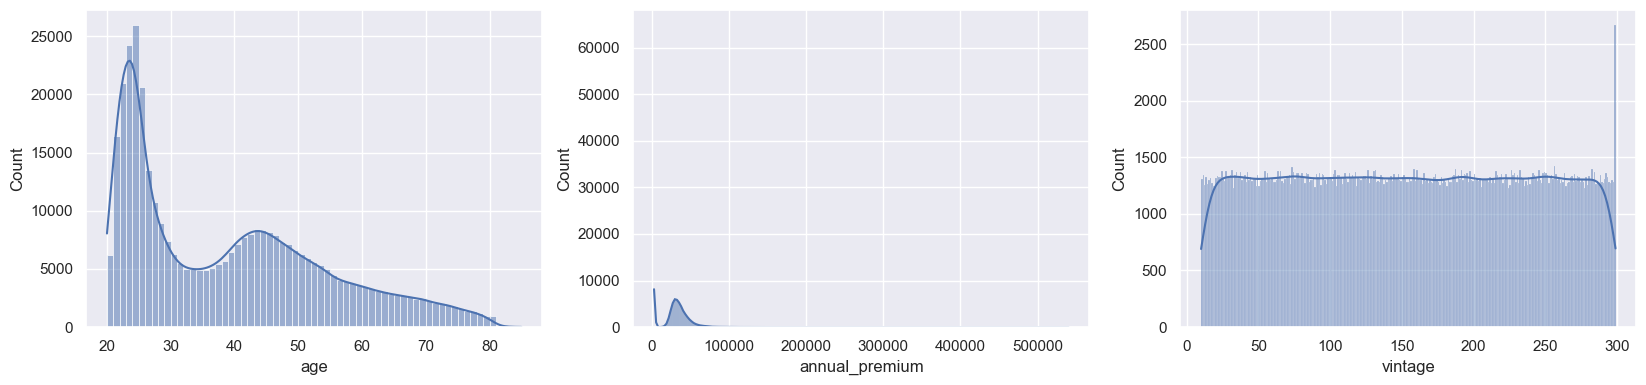

In [61]:
plt.figure(figsize=(20,14))

plt.subplot( 3, 3, 1 )
aux1 = sns.histplot(df1['age'], binwidth=1, kde=True);
plt.subplot( 3, 3, 2 )
aux2 = sns.histplot(df1['annual_premium'], kde=True);
plt.subplot( 3, 3, 3 )
aux3 = sns.histplot(df1['vintage'], binwidth=1, kde=True);

### 1.5.2 Categorical Attributes


In [64]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64

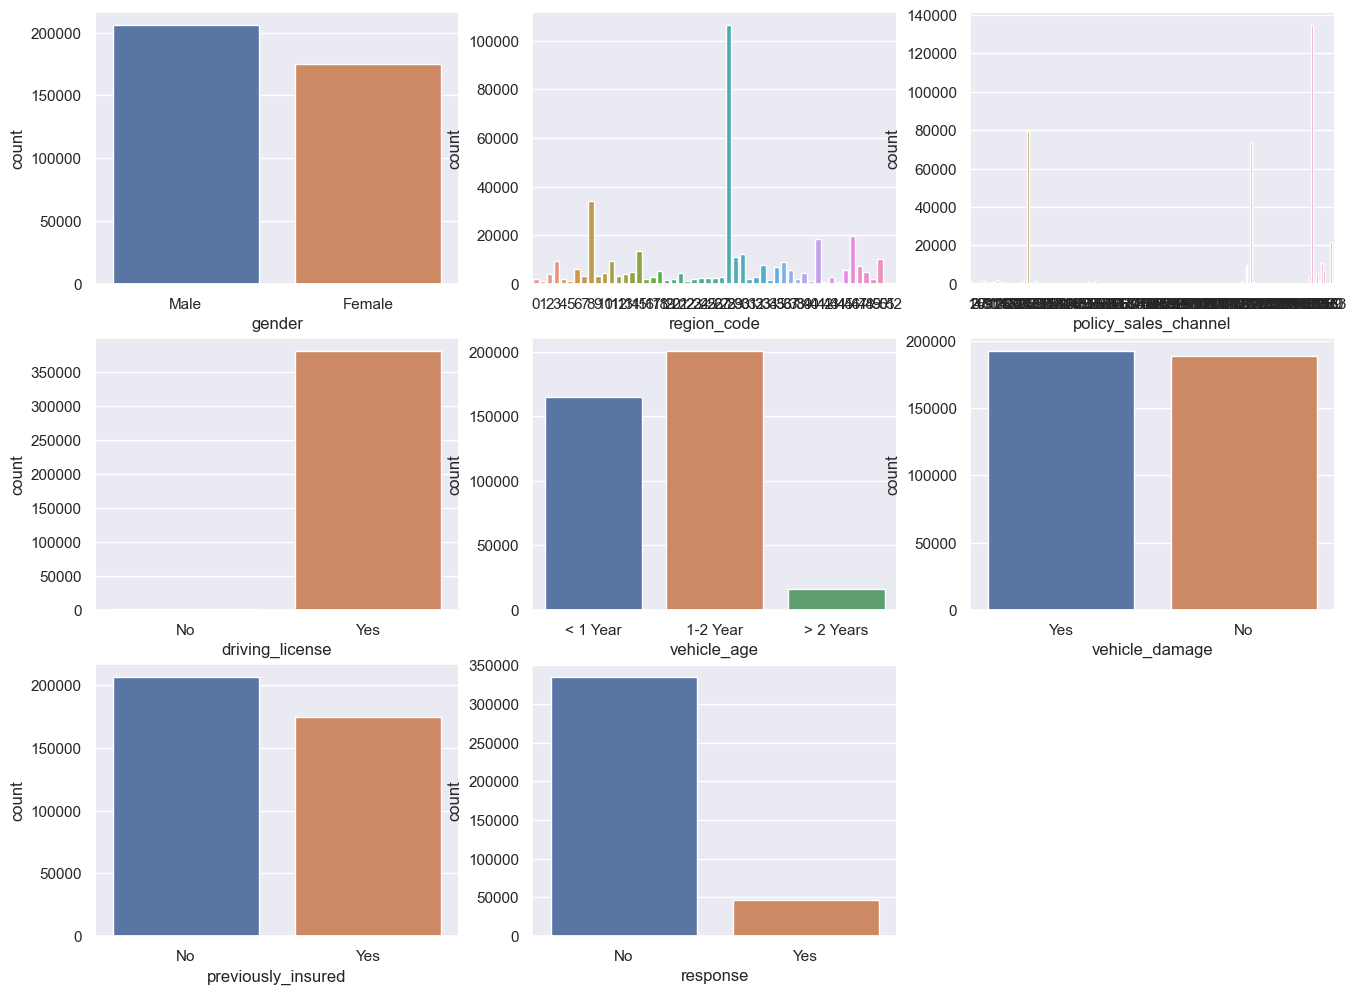

In [71]:
plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['previously_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);

# 2. Feature Engineering



In [5]:
df2 = df1.copy()

In [6]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else 'below_1_year')
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [12]:
df2.head().T

,0,1,2,3,4
id,7,13,18,31,39
gender,Male,Female,Female,Female,Male
age,23,41,25,26,45
region_code,11,15,35,8,8
policy_sales_channel,152,14,152,160,124
driving_license,1,1,1,1,1
vehicle_age,below_1_year,between_1_2_years,below_1_year,below_1_year,between_1_2_years
vehicle_damage,1,0,0,0,1
previously_insured,0,1,1,0,0
annual_premium,23367.0,31409.0,46622.0,2630.0,42297.0


# 3. Filtragem de Variáveis


In [8]:
# df3 = df2.copy()

# 4. Análise Exploratória dos Dados



## 4.1 Análise Univariada

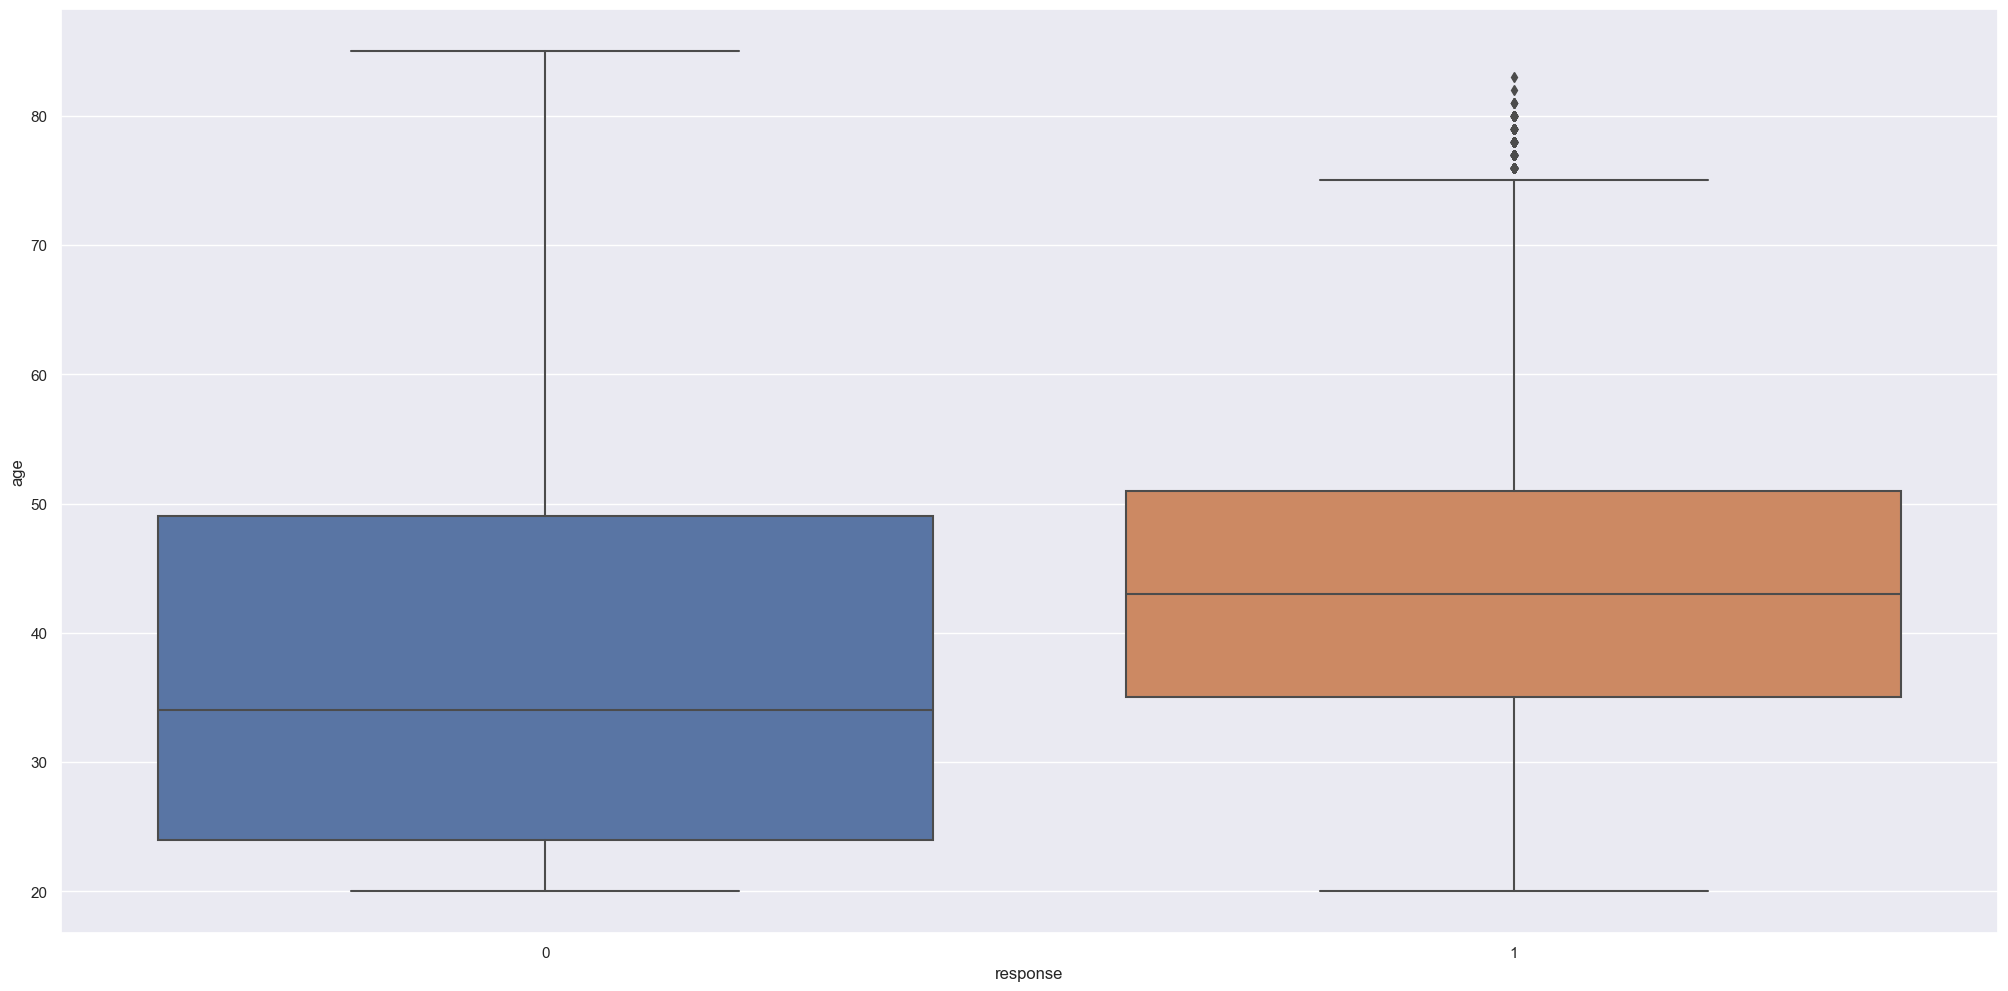

In [9]:
sns.boxplot(x='response', y='age', data=df2);

##### Nota-se que pessoas mais velhas tem maior propensão em adquirir um novo tipo de seguro do que as mais novas

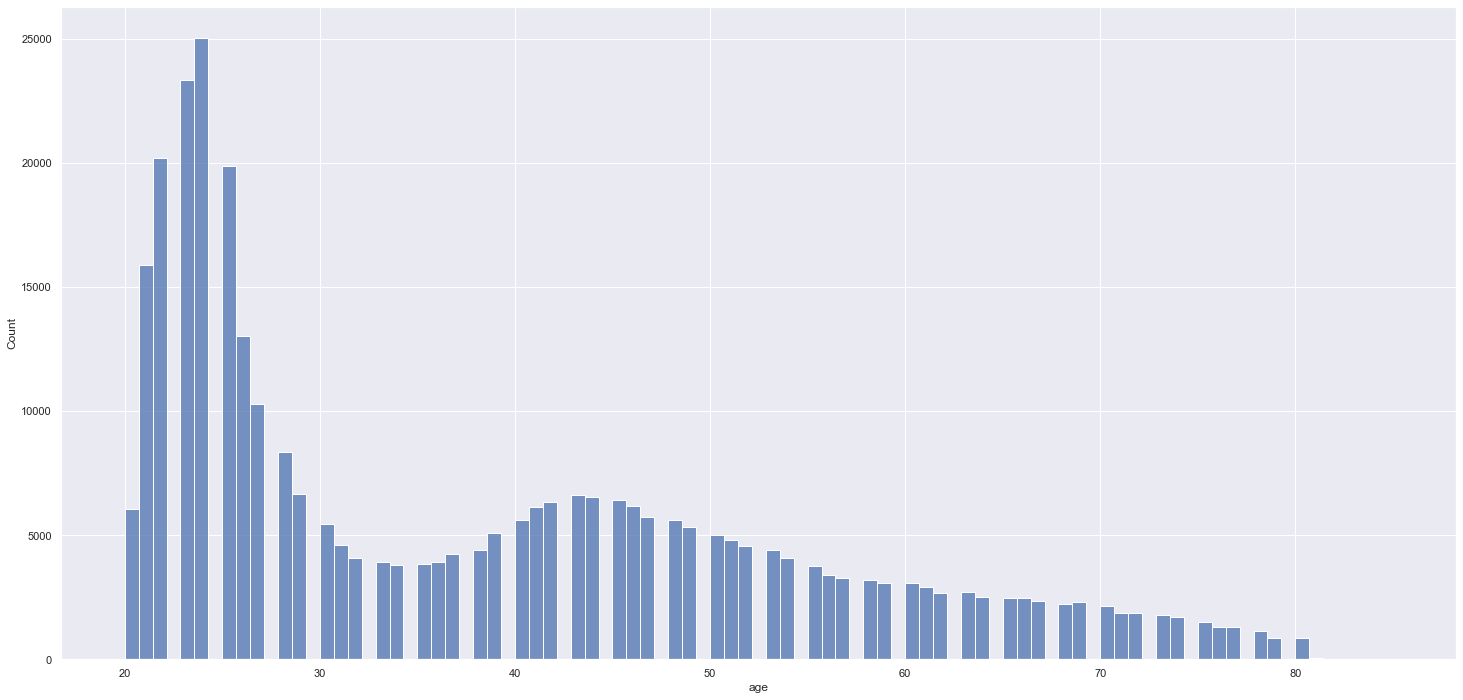

In [48]:
aux1 = df2.loc[df3['response'] == 0, 'age']
sns.histplot( aux1 );

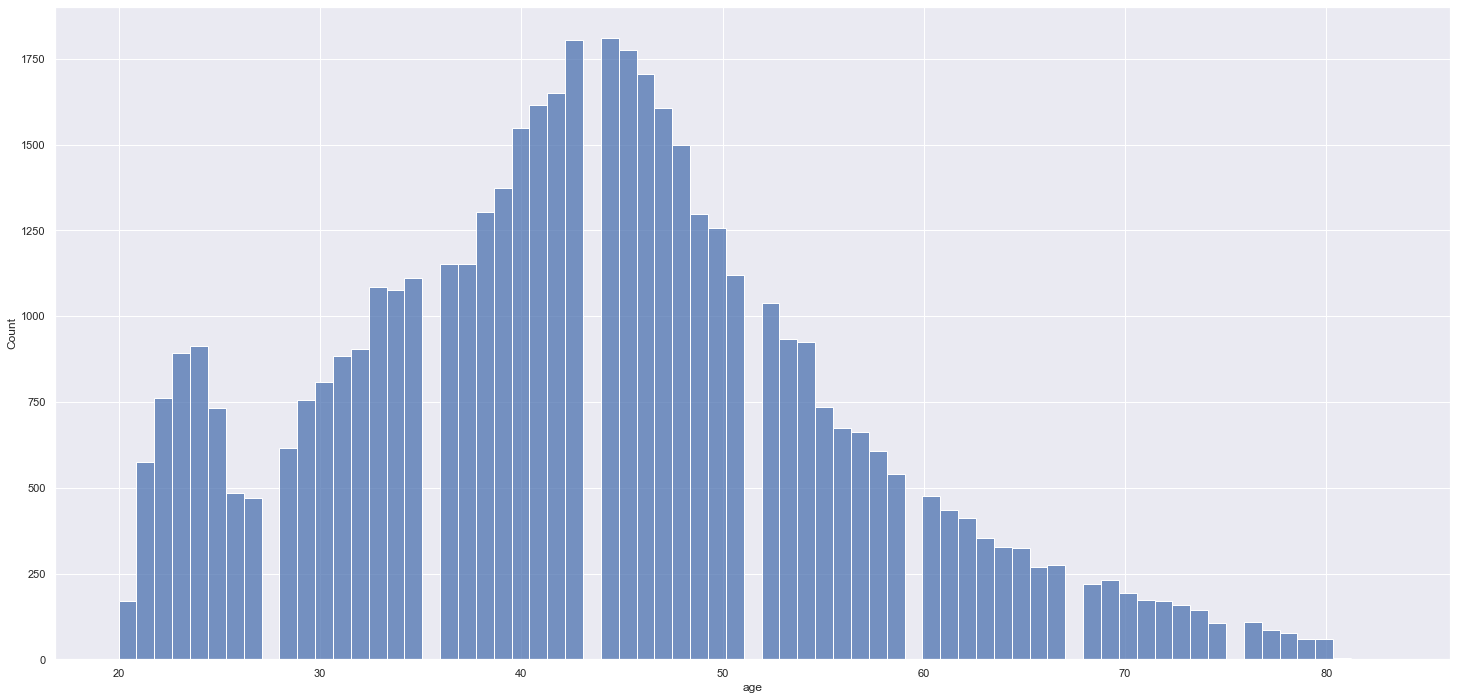

In [50]:
aux2 = df2.loc[df2['response'] == 1, 'age']
sns.histplot( aux2 );

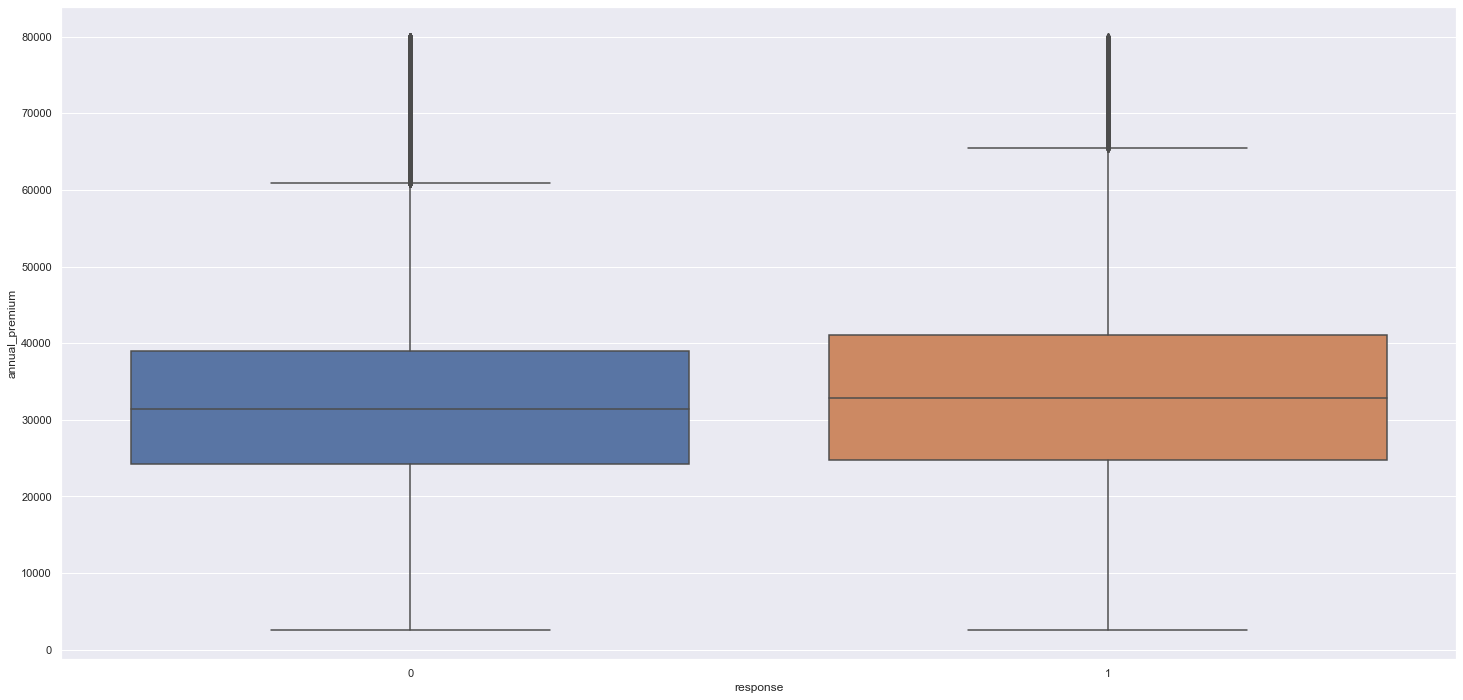

In [79]:
# annual_premmium
aux = df2[df2['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

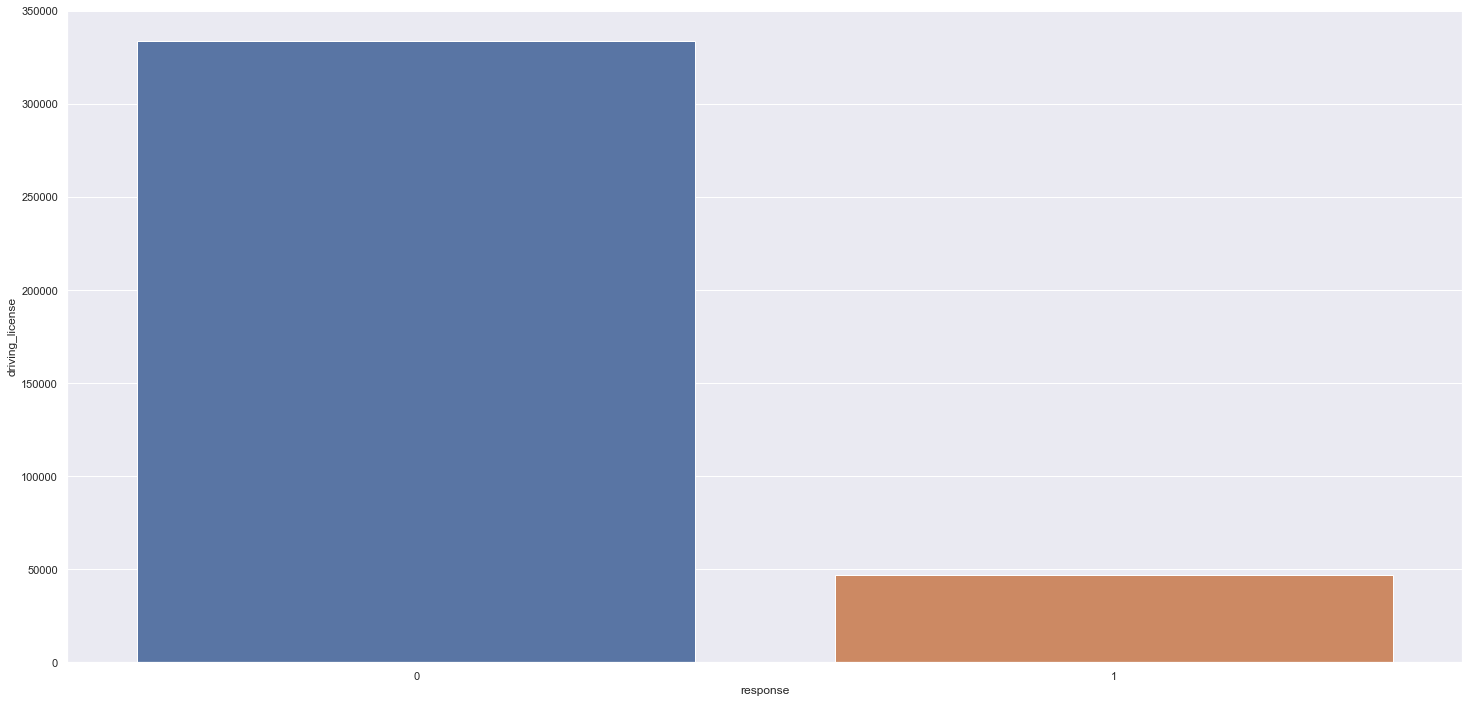

In [61]:
# driving license
aux = df2[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x= 'response', y='driving_license', data=aux);

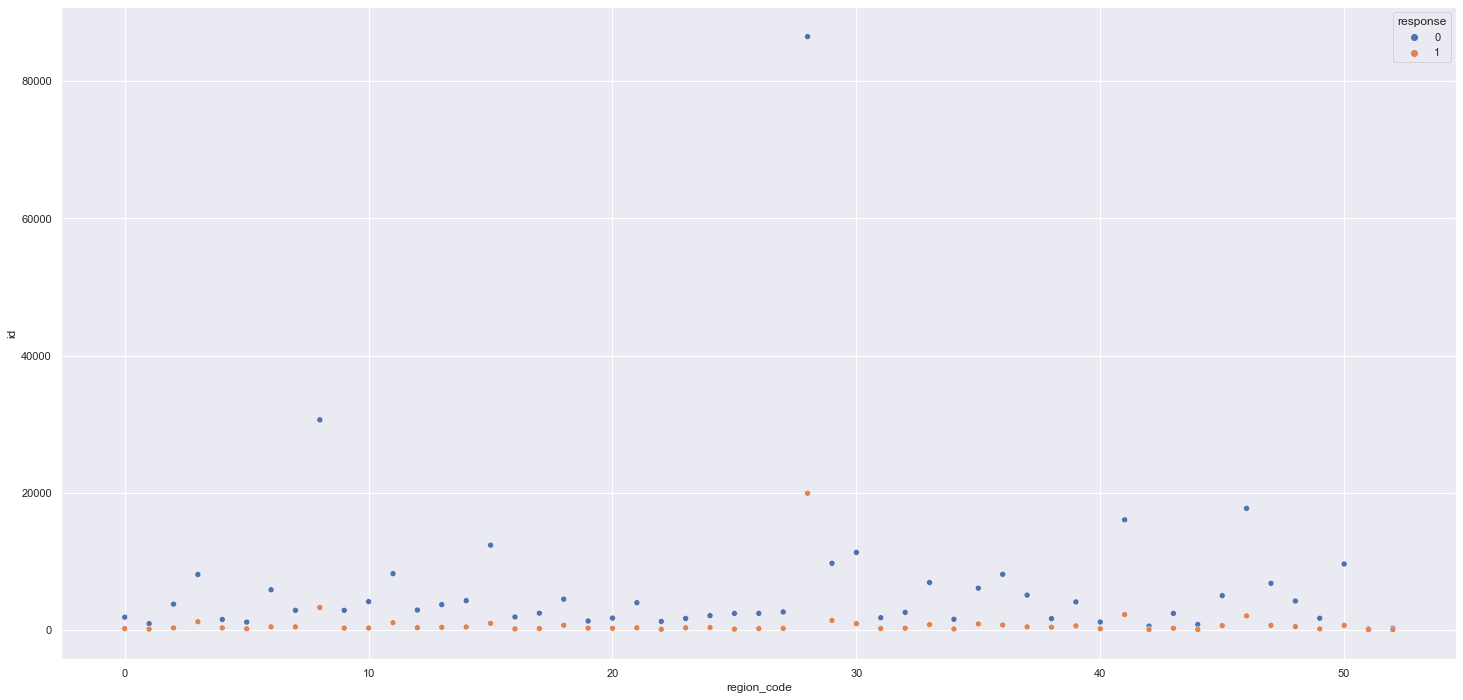

In [69]:
# region code
aux0= df2[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x= 'region_code', y='id', hue='response', data=aux0);

In [72]:
# previously_insured
pd.crosstab(df2['previously_insured'], df2['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [74]:
# vehicle_age
df2[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


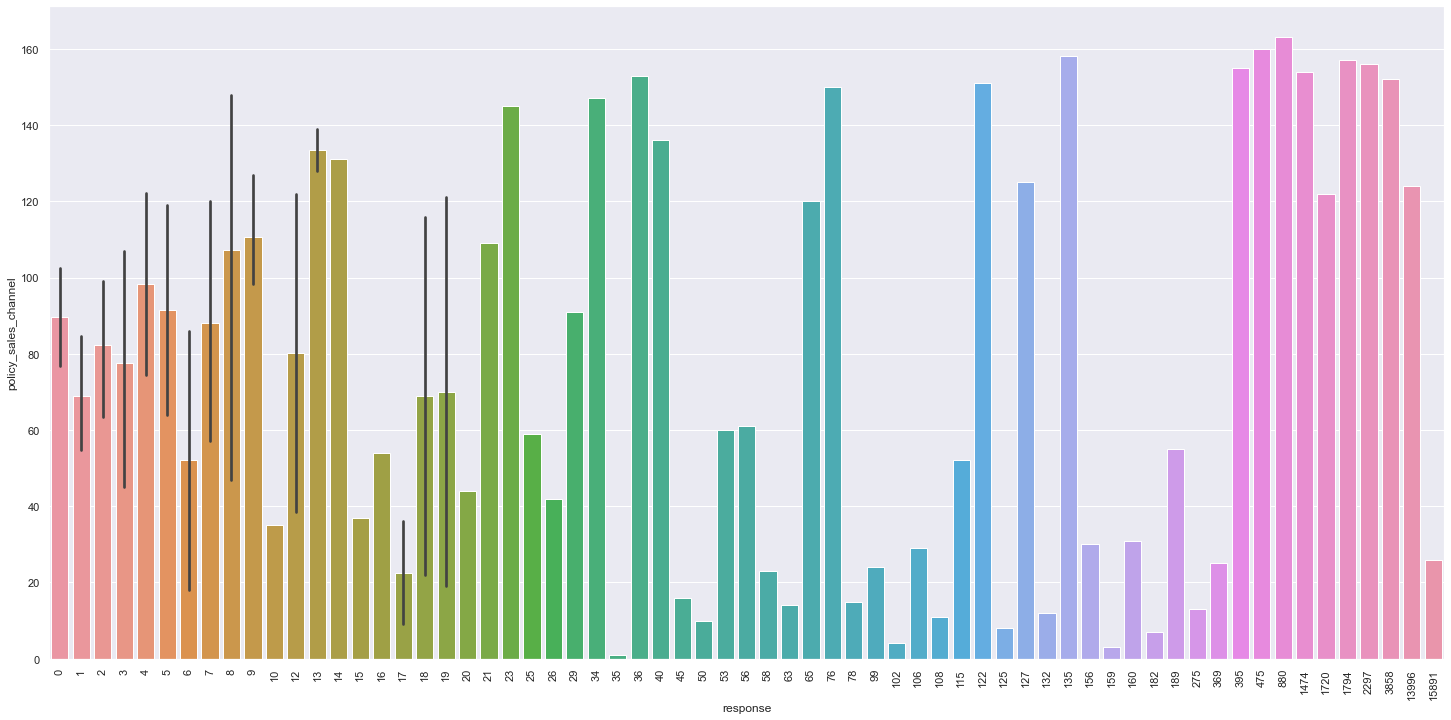

In [75]:
# policy_sales_channel - bar percentage chat python
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)
plt.xticks(rotation=90);

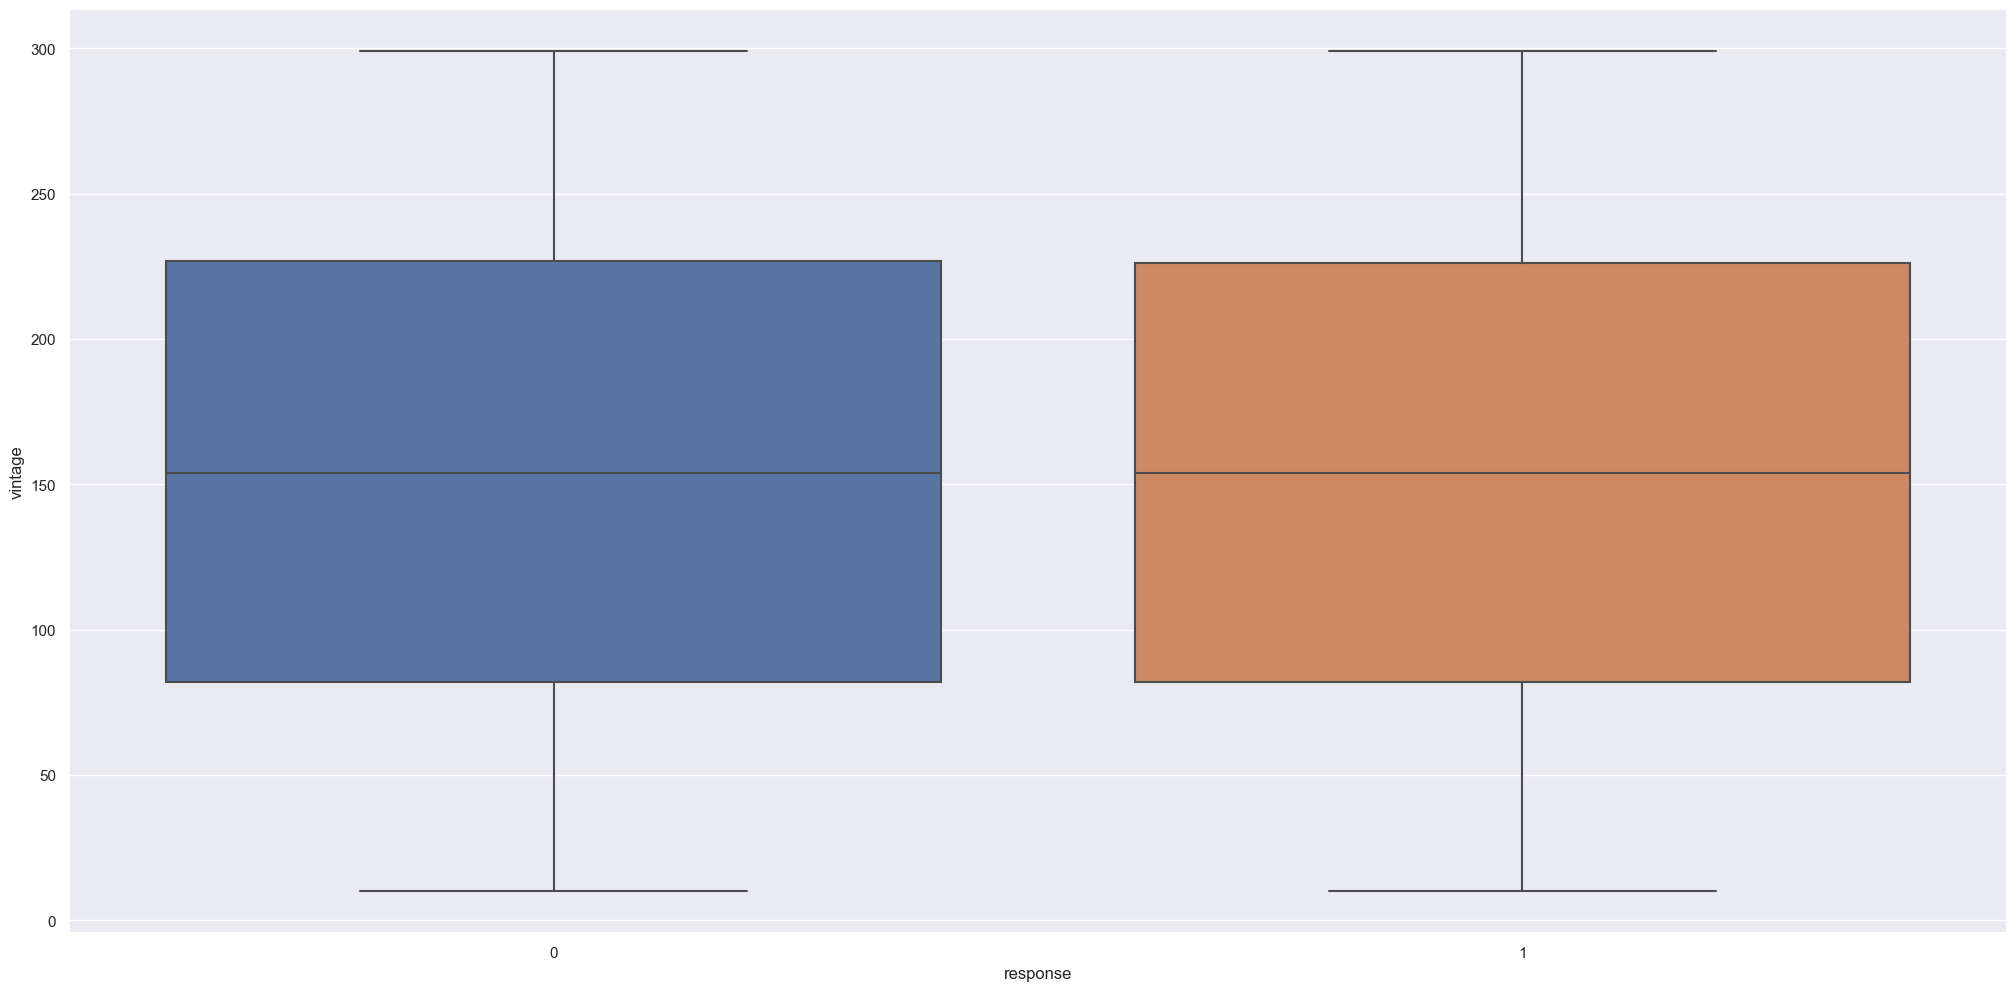

In [10]:
# vintage
sns.boxplot(x='response', y='vintage', data=df2);

# 5. Preparação dos Dados

In [7]:
df3 = df2.copy()

In [8]:
X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20)

df3 =pd.concat([x_train, y_train], axis=1)

## 5.1 Standardzation




In [9]:
s_scaler = pp.StandardScaler()

# annual premium
df3['annual_premium'] = s_scaler.fit_transform(df3[['annual_premium']].values)

## 5.2 Scaling


In [10]:
# utilizar mms para variaveis de natureza ciclica. meses, dias, semanas,
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df3['age'] = mms_age.fit_transform(df3[['age']].values )

# vintage
df3['vintage'] = mms_vintage.fit_transform(df3[['vintage']].values )

## 5.3 Enconding


In [11]:
 # gender - One Hot Encoding / Target Encoding
target_encode_gender = df3.groupby( 'gender' )['response'].mean()
df3.loc[:, 'gender'] = df3['gender'].map( target_encode_gender )
# pickle.dump( target_encode_gender, open( 'parameter\\target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df3.groupby( 'region_code' )['response'].mean()
df3.loc[:, 'region_code'] = df3['region_code'].map( target_encode_region_code )
# pickle.dump( target_encode_region_code, open( 'parameter\\target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df3 = pd.get_dummies(df3, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df3.groupby( 'policy_sales_channel' ).size() / len( df3 ) 
df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map( fe_policy_sales_channel )
# pickle.dump( fe_policy_sales_channel, open( 'parameter\\fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4 Validation Preparation

In [12]:
x_validation_data = x_validation.copy()

In [13]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = s_scaler.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

## Feature Selection


In [14]:
df4 = df3.copy()

### 6.1 Features Importance


In [15]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=42, n_jobs=-1)

# data preparation
x_train_n = df4.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)
# encontrando a importancia das features

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                         feature  importance
0                        vintage    0.274030
0                 annual_premium    0.245292
0                            age    0.164738
0                    region_code    0.104732
0                 vehicle_damage    0.072011
0           policy_sales_channel    0.058877
0             previously_insured    0.053398
0       vehicle_age_below_1_year    0.012546
0  vehicle_age_between_1_2_years    0.006225
0                         gender    0.004977
0       vehicle_age_over_2_years    0.002693
0                driving_license    0.000483


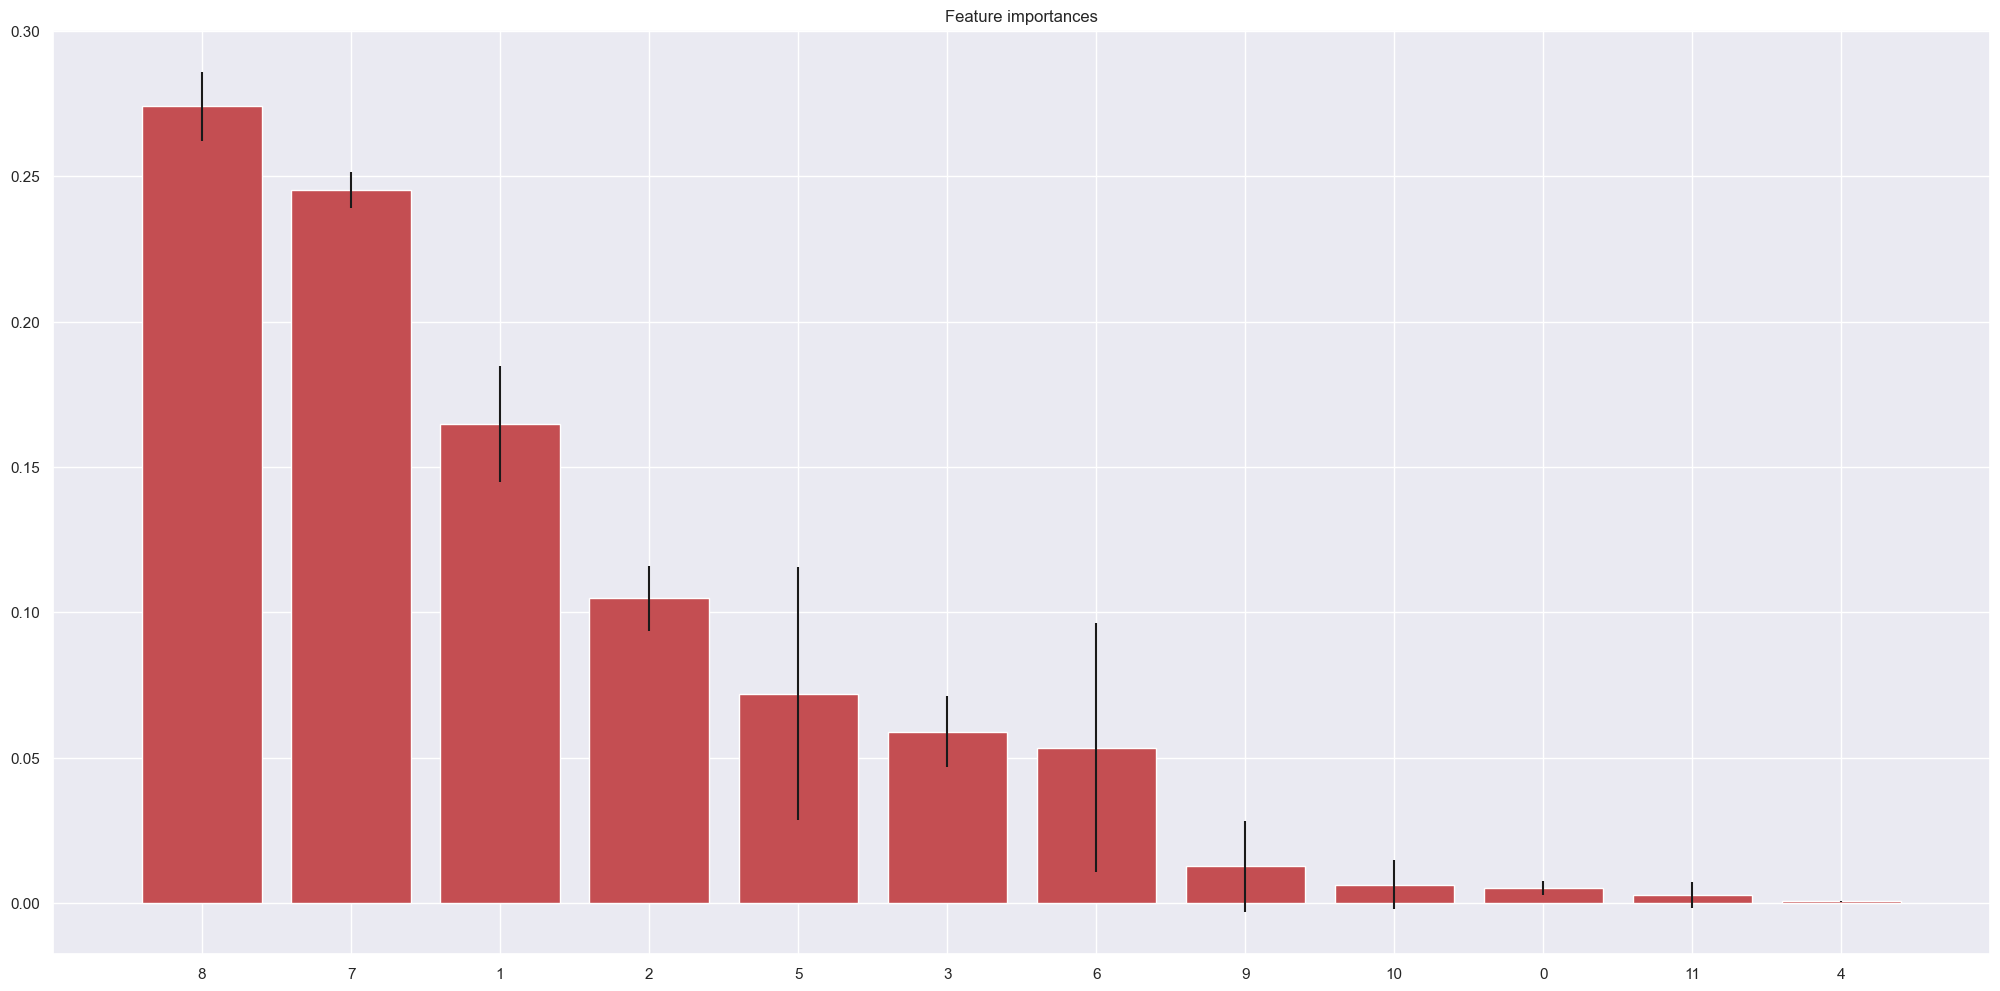

In [19]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7. Machile Learning



In [15]:
df5 = x_validation.copy()
df5['response'] = y_validation.copy()

In [16]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

### 7.1 KNN


In [17]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=2)

# model training
knn_model.fit(x_train, y_train)

# model prediction - mede o poder de generalização do meu modelo 
yhat_knn = knn_model.predict_proba(x_val)

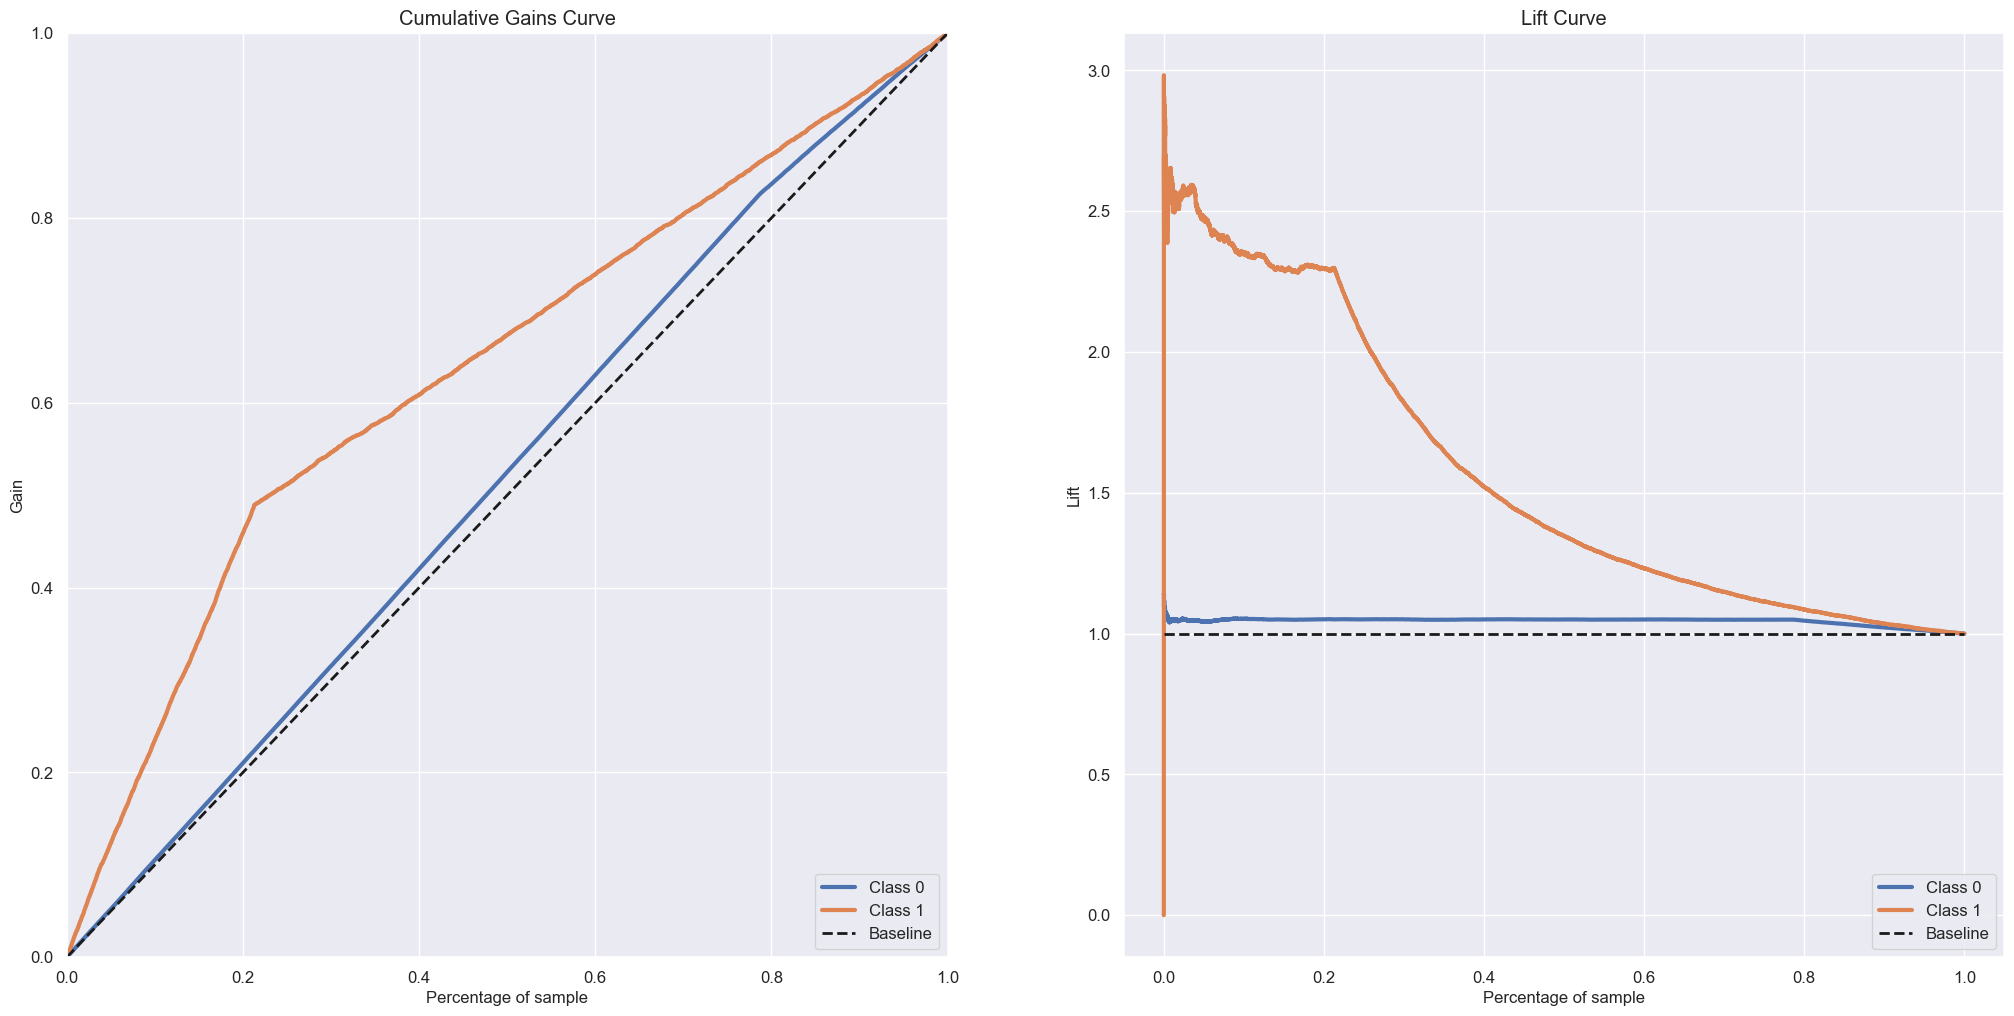

In [18]:
fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axs[1]);

In [19]:
df5_knn = df5.copy()

# propensity_score
df5_knn['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df5_knn = df5_knn.sort_values('score', ascending=False)

# compute precision at k 
precision_at_k_knn, data = precision_at_k(df5_knn, k=2000)

# compute recall at k
recall_at_k_knn, data = recall_at_k(df5_knn, k=2000)

models_performance_knn = pd.DataFrame({'Model':['KNN'], "precision_at_k": [precision_at_k_knn], "recall_at_k": [recall_at_k_knn]}) 
models_performance_knn

,Model,precision_at_k,recall_at_k
0,KNN,0.31934,0.067885


### 7.2 Logistic Regression



In [20]:
# model definition / # testar PCA
lr_model = lm.LogisticRegression(random_state=42) 

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

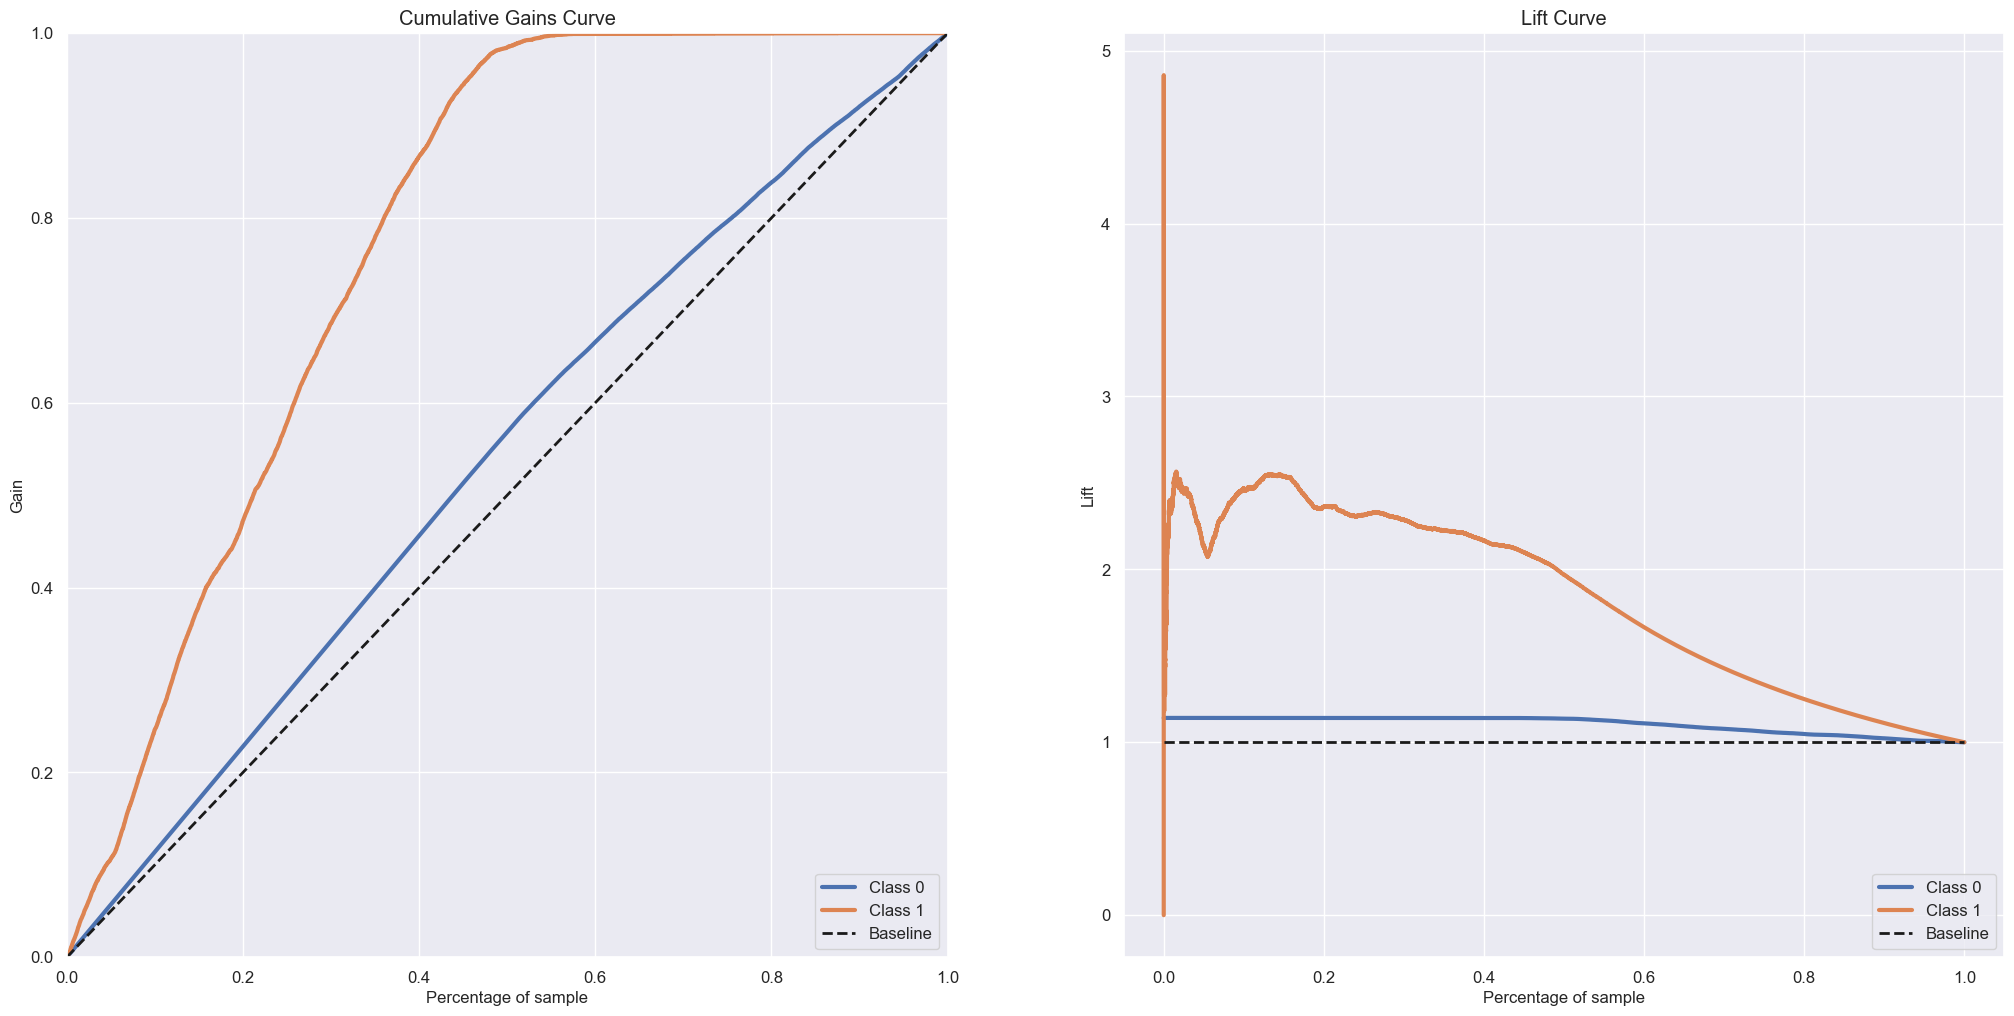

In [21]:
fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=axs[1]);

###### Nota-se que se eu pegar 50% da minha base ordenada, eu tenho 100% dos meus clientes ordenados, no caso utilizando LR.


In [22]:
df5_lr = df5.copy()

# propensity_score
df5_lr['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df5_lr = df5_lr.sort_values('score', ascending=False)

# compute precision at k 
precision_at_k_lr, data = precision_at_k(df5_lr, k=2000)

# compute recall at k
recall_at_k_lr, data = recall_at_k(df5_lr, k=2000)

models_performance_lr = pd.DataFrame({'Model':['LR'], "precision_at_k": [precision_at_k_lr], "recall_at_k": [recall_at_k_lr]}) 
models_performance_lr

,Model,precision_at_k,recall_at_k
0,LR,0.302849,0.064379


## 7.3 Random Forest


In [23]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1)

# model fit
rf.fit(x_train, y_train)

# model predict
yhat_rf = rf.predict_proba(x_val)

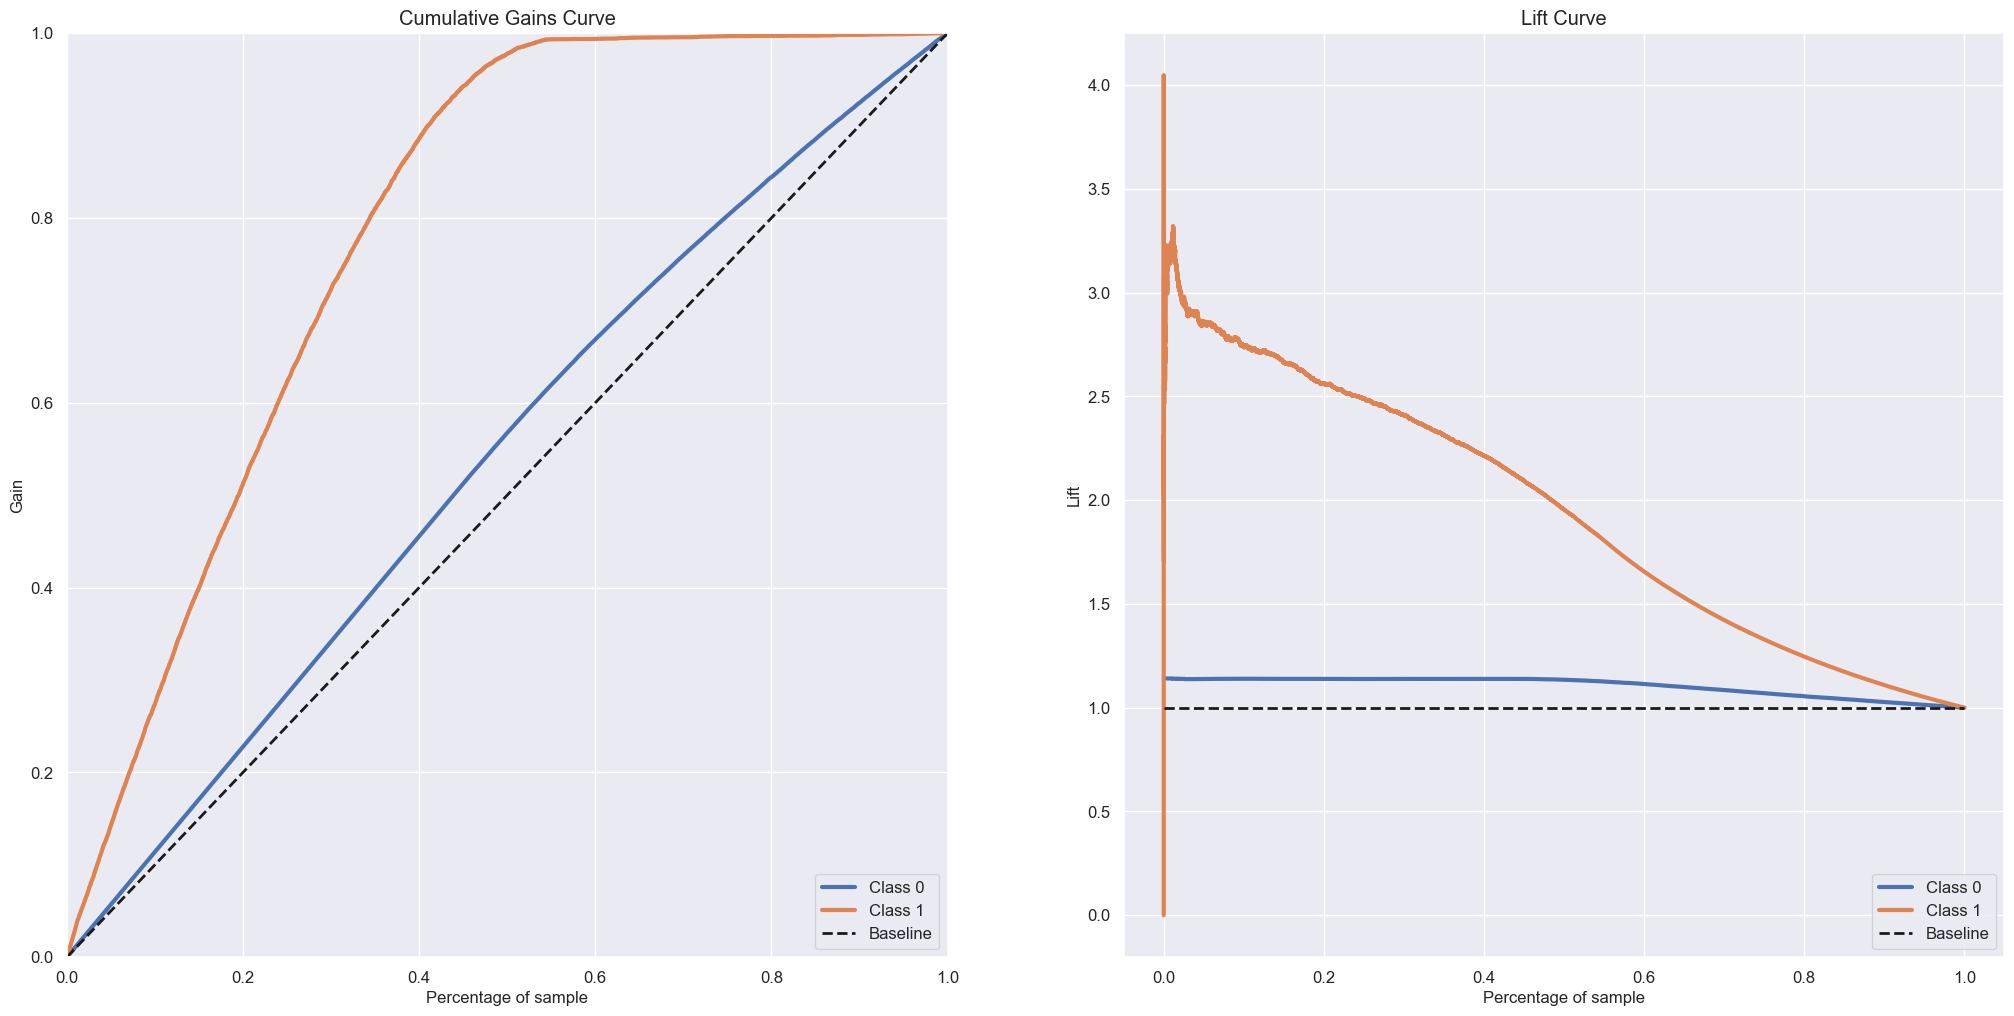

In [24]:
fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax=axs[1]);

In [25]:
df5 = df5.copy()

# propensity_score
df5['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df5 = df5.sort_values('score', ascending=False)

# compute precision at k 
precision_at_k_rf, data = precision_at_k(df5, k=2000)

# compute recall at k
recall_at_k_rf, data = recall_at_k(df5, k=2000)

models_performance_rf = pd.DataFrame({'Model':['Random Forest'], "precision_at_k": [precision_at_k_rf], "recall_at_k": [recall_at_k_rf]}) 
models_performance_rf

,Model,precision_at_k,recall_at_k
0,Random Forest,0.366317,0.077871


## 7.4 XGBoost 




In [26]:
# model definition
xgb_model = xgb.XGBClassifier()

# model fit
xgb_model.fit(x_train, y_train)

# model predict
yhat_xgb = xgb_model.predict_proba(x_val)

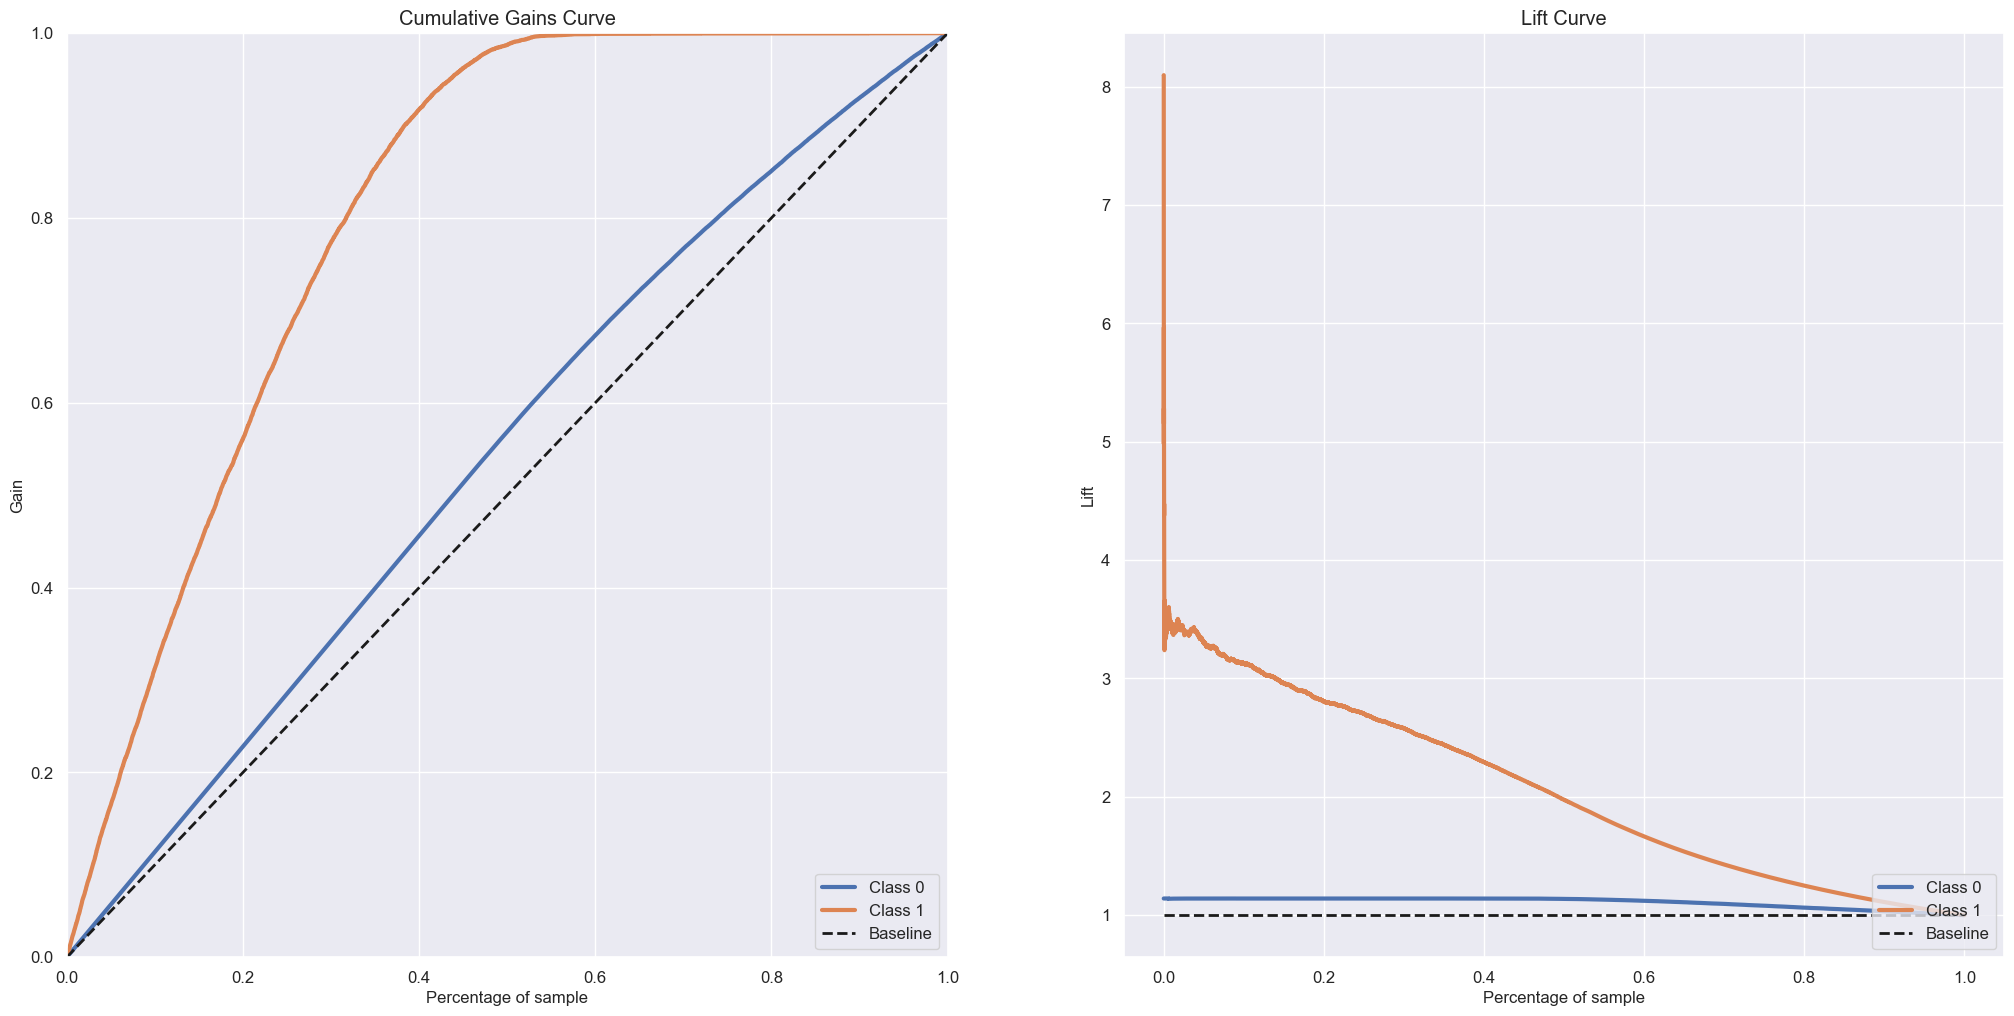

In [27]:
fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax=axs[1]);

In [28]:
df5_xgb = df5.copy()

# propensity_score
df5_xgb['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df5_xgb = df5_xgb.sort_values('score', ascending=False)

# compute precision at k 
precision_at_k_xgb, data = precision_at_k(df5_xgb, k=2000)

# compute recall at k
recall_at_k_xgb, data = recall_at_k(df5_xgb, k=2000)

models_performance_xgb = pd.DataFrame({'Model':['XGBoost'], "precision_at_k": [precision_at_k_xgb], "recall_at_k": [recall_at_k_xgb]}) 
models_performance_xgb

,Model,precision_at_k,recall_at_k
0,XGBoost,0.141429,0.030065


## 7.5 LightGBM


In [29]:
# model definition
lgbm = LGBMClassifier()

# model fit
lgbm.fit(x_train, y_train)

# model predict
yhat_lgbm = lgbm.predict_proba(x_val)

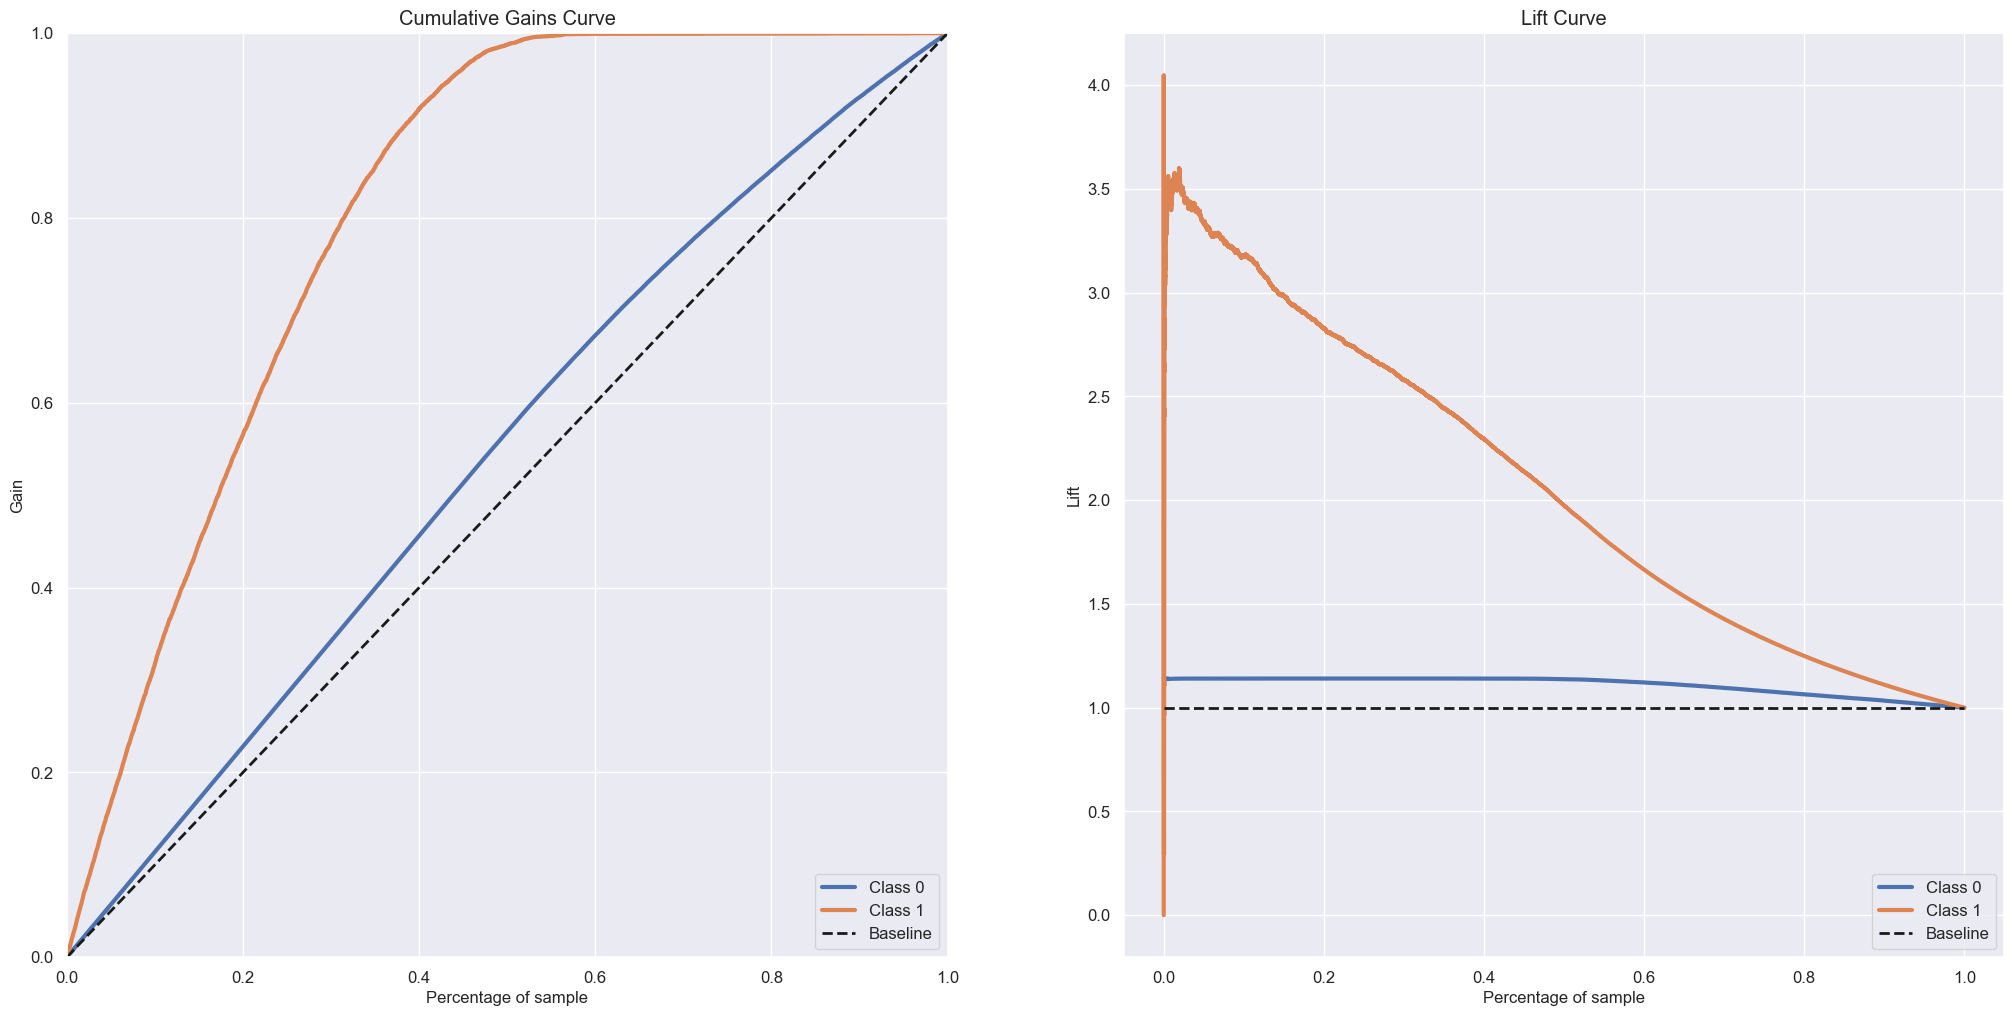

In [30]:
fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm, ax=axs[1]);

In [31]:
df5_lgbm = df5.copy()

# propensity_score
df5_lgbm['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df5_lgbm = df5_lgbm.sort_values('score', ascending=False)

# compute precision at k 
precision_at_k_lgbm, data = precision_at_k(df5_lgbm, k=2000)

# compute recall at k
recall_at_k_lgbm, data = recall_at_k(df5_lgbm, k=2000)

models_performance_lgbm = pd.DataFrame({'Model':['LightGBM'], "precision_at_k": [precision_at_k_lgbm], "recall_at_k": [recall_at_k_lgbm]}) 
models_performance_lgbm

,Model,precision_at_k,recall_at_k
0,LightGBM,0.133433,0.028365


## Models Performance


### Single Performance

In [32]:
# selection all models
models_performance = pd.concat([models_performance_knn, 
                                models_performance_lr, 
                                models_performance_rf, 
                                models_performance_xgb, 
                                models_performance_lgbm])
                                
models_performance.sort_values('precision_at_k', ascending=False)

,Model,precision_at_k,recall_at_k
0,Random Forest,0.366317,0.077871
0,KNN,0.319340,0.067885
0,LR,0.302849,0.064379
0,XGBoost,0.141429,0.030065
0,LightGBM,0.133433,0.028365


### Cross Validation Performance

In [33]:
models_performance_cv = pd.DataFrame({'Model':[], "precision_at_k":[], "recall_at_k":[]})

models_performance_cv = cross_validation(models_performance_cv, 5 , 'KNN CV', knn_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Logistic Regression CV', lr_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest CV', rf, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost CV', xgb_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM CV', lgbm, x_train, y_train)

models_performance_cv.sort_values('precision_at_k', ascending=False)

,Model,precision_at_k,recall_at_k
0,LightGBM CV,0.4182 +/- 0.0109,0.112 +/- 0.0029
0,XGBoost CV,0.4062 +/- 0.0162,0.109 +/- 0.0044
0,Random Forest CV,0.3538 +/- 0.0091,0.095 +/- 0.0026
0,KNN CV,0.3104 +/- 0.0122,0.0832 +/- 0.0031
0,Logistic Regression CV,0.2934 +/- 0.0129,0.0788 +/- 0.0033


## 8. Fine Tuning




### 8.1 Random Search

In [40]:
param = {'n_estimators':[1000, 1500, 2000],
         'learning_rate':[0.1, 0.01, 0.001],
         'num_leaves':[10, 35, 50],
         'max_depth':[15, 35, 50],
         'min_child_samples':[100, 300, 500],
         'min_child_weight':[0.001, 1.0, 100.0],         
         'subsample':[0.5, 0.8, 1.0],
         'colsample_bytree':[0.5, 0.8, 1.0],
        }

max_eval = 3

In [43]:
final_result = pd.DataFrame()

for i in range(max_eval):    
    hp = { k:random.choice( v ) for k, v in param.items()}
    print("Iteration {}: {}".format(i + 1, hp))

    lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1,
                                n_estimators=hp['n_estimators'],
                                learning_rate=hp['learning_rate'],
                                num_leaves=hp['num_leaves'],
                                max_depth=hp['max_depth'],
                                min_child_samples=hp['min_child_samples'],
                                min_child_weight=hp['min_child_weight'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
#                                 reg_alpha=hp['reg_alpha'],
#                                 reg_lambda=hp['reg_lambda'],
                               )
    
    name = 'LightGBM CV' + ' {}'.format(i + 1)

    # pemodel_xgbormance
    final_result = cross_validation(final_result, 5 , name, lgbm_tuned, x_train, y_train)

final_result.sort_values('precision_at_k', ascending=False)

Iteration 1: {'n_estimators': 2000, 'learning_rate': 0.1, 'num_leaves': 10, 'max_depth': 15, 'min_child_samples': 500, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.5}
Iteration 2: {'n_estimators': 1500, 'learning_rate': 0.001, 'num_leaves': 10, 'max_depth': 35, 'min_child_samples': 100, 'min_child_weight': 0.001, 'subsample': 0.5, 'colsample_bytree': 0.8}
Iteration 3: {'n_estimators': 1500, 'learning_rate': 0.1, 'num_leaves': 35, 'max_depth': 50, 'min_child_samples': 300, 'min_child_weight': 1.0, 'subsample': 0.5, 'colsample_bytree': 1.0}


,Model,precision_at_k,recall_at_k
0,LightGBM CV 1,0.41 +/- 0.01,0.1102 +/- 0.0025
0,LightGBM CV 2,0.4094 +/- 0.0066,0.1098 +/- 0.0017
0,LightGBM CV 3,0.39 +/- 0.0097,0.1046 +/- 0.0027


### 8.2 Final Model


In [59]:
# Iteration 1: {'n_estimators': 2000, 'learning_rate': 0.1, 'num_leaves': 10, 'max_depth': 15, 'min_child_samples': 500, 'min_child_weight': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.5}

param_tuned = {'n_estimators': 2000, 
               'learning_rate': 0.1, 
               'num_leaves': 10, 
               'max_depth': 15, 
               'min_child_samples': 500, 
               'min_child_weight': 1.0, 
               'subsample': 1.0, 
               'colsample_bytree': 0.5, 
              }

In [60]:
# model -  can use tree_method ='gpu_hist' to run on gpu
lgbm_tuned = LGBMClassifier(random_state=42, 
                            n_jobs=-1,
                            n_estimators=param_tuned['n_estimators'],
                            learning_rate=param_tuned['learning_rate'],
                            num_leaves=param_tuned['num_leaves'],
                            max_depth=param_tuned['max_depth'],
                            min_child_samples=param_tuned['min_child_samples'],
                            min_child_weight=param_tuned['min_child_weight'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            )

# train
lgbm_tuned.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.5, max_depth=15, min_child_samples=500,
               min_child_weight=1.0, n_estimators=2000, num_leaves=10,
               random_state=42)

In [47]:
# performance
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Tuned CV', lgbm_tuned, x_train, y_train)
models_performance_cv.sort_values('precision_at_k', ascending=False)

,Model,precision_at_k,recall_at_k
0,LightGBM CV,0.4264 +/- 0.0069,0.1144 +/- 0.002
0,XGBoost CV,0.412 +/- 0.0028,0.1108 +/- 0.0007
0,LightGBM Tuned CV,0.41 +/- 0.01,0.1102 +/- 0.0025
0,Random Forest CV,0.348 +/- 0.0094,0.0934 +/- 0.0023
0,KNN CV,0.3098 +/- 0.0129,0.0832 +/- 0.0035
0,Logistic Regression CV,0.3 +/- 0.0092,0.0806 +/- 0.0022


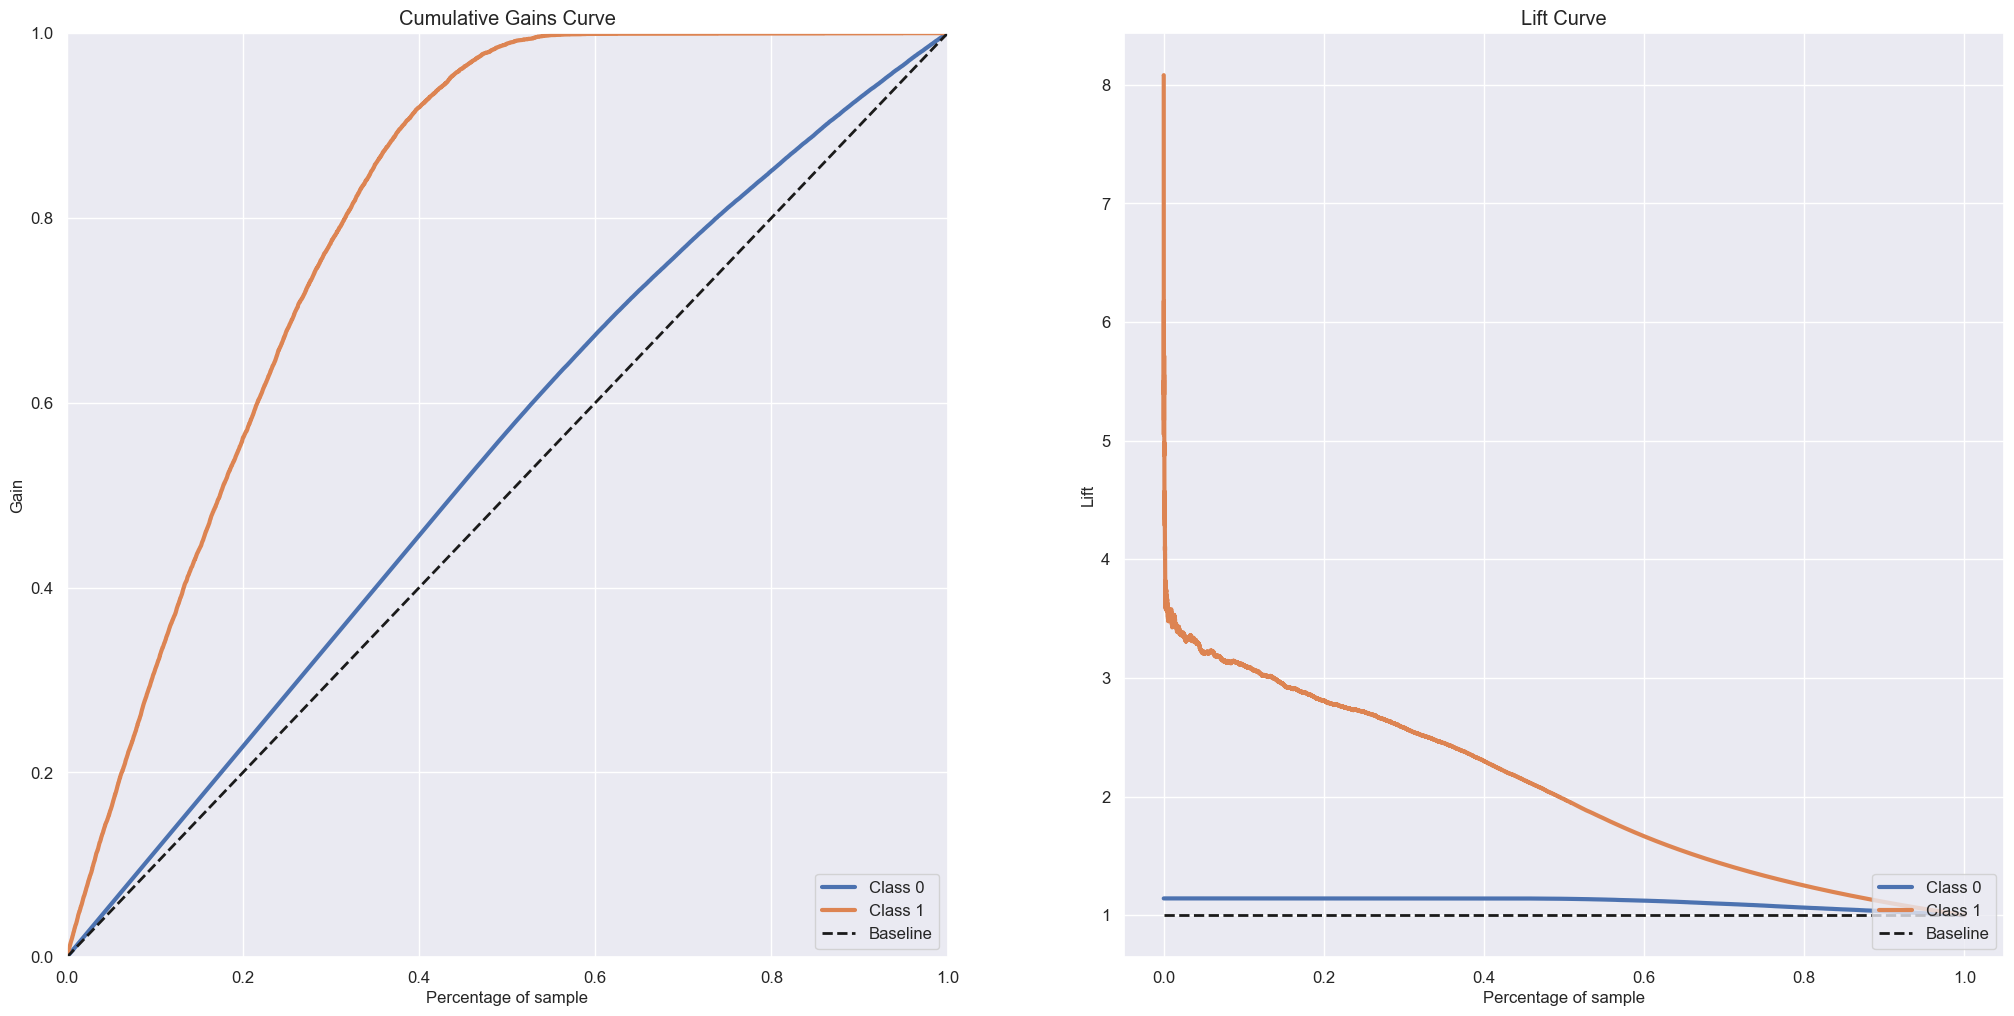

In [48]:
yhat_lgbm_tuned = lgbm_tuned.predict_proba(x_val)

fig, axs = plt.subplots(ncols=2)

# cumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_tuned, ax=axs[0]);

# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm_tuned, ax=axs[1]);

## 9. Business Performance

In [34]:
df_complete = df2.copy()
df_complete.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,below_1_year,1,0,23367.0,249,0
1,13,Female,41,15,14,1,between_1_2_years,0,1,31409.0,221,0
2,18,Female,25,35,152,1,below_1_year,0,1,46622.0,299,0
3,31,Female,26,8,160,1,below_1_year,0,0,2630.0,136,0
4,39,Male,45,8,124,1,between_1_2_years,1,0,42297.0,264,0


In [35]:
# gender
df_complete['gender'] =  df_complete.loc[:, 'gender'].map(target_encode_gender)

# age
df_complete.loc[:, 'age'] = mms_age.transform(df_complete[['age']].values)

# region_code
df_complete.loc[:, 'region_code'] = df_complete.loc[:, 'region_code'].map(target_encode_region_code)

#vehicle_age

df_complete = pd.get_dummies(df_complete, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
df_complete.loc[:, 'annual_premium'] = s_scaler.transform(df_complete[['annual_premium']].values)

# policy_sales_channel
df_complete.loc[:, 'policy_sales_channel'] = df_complete['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
df_complete.loc[:, 'vintage'] = mms_vintage.transform(df_complete[['vintage']].values)

# fillna
df_complete = df_complete.fillna(0)

In [66]:
df_complete[cols_selected].head()

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel
0,-0.416847,0.826990,0.046154,0.109875,1,0,0.354203
1,0.048664,0.730104,0.323077,0.071308,0,1,0.001620
2,0.929268,1.000000,0.076923,0.127698,0,1,0.354203
3,-1.617207,0.435986,0.092308,0.096506,0,0,0.056759
4,0.678916,0.878893,0.384615,0.096506,1,0,0.194101


In [61]:
# propensity_score
yhat_lgbm_tuned_complete = lgbm_tuned.predict_proba(df_complete[cols_selected])

df_complete['proba_0'] = yhat_lgbm_tuned_complete[:, 0].tolist()
df_complete['proba_1'] = yhat_lgbm_tuned_complete[:, 1].tolist()

In [62]:
# get 2000 random clients in the dataset
df_complete_2000_random = df_complete.sample(2000)

# sort clients by propensity score
df_complete_2000_sorted = df_complete.sort_values('proba_1', ascending=False).iloc[0:1999]

In [63]:
df_complete_2000_random_counts = pd.DataFrame(df_complete_2000_random['response'].value_counts())
df_complete_2000_random_counts

,response
0,1737
1,263


In [64]:
df_complete_2000_sorted_counts = pd.DataFrame(df_complete_2000_sorted['response'].value_counts())
df_complete_2000_sorted_counts

,response
1,1154
0,845


In [65]:
df_percentage = ((((df_complete_2000_sorted_counts.loc[1, 'response'] / df_complete_2000_random_counts.loc[1, 'response'])) * 100) -100).round(2)
df_diff = df_complete_2000_sorted_counts.loc[1, 'response'] - df_complete_2000_random_counts.loc[1, 'response']
print("Number of clients increased in the sorted dataset compared to the unsorted: {}".format(df_diff))
print("Percentage increase in the number of clients: {}%".format(df_percentage))

Number of clients increased in the sorted dataset compared to the unsorted: 891
Percentage increase in the number of clients: 338.78%
